# Idea
    at first we want to extract a features and based on that  get the info

First, which model should we choose for the Image pretrining?
if you ask LLM's VGG is no brainer, thats because they have feed too many github repos which uses VGG to solve this problem, but in reality we can far better and newer models, as for me , i am choosing efficentNets, smaller lower FLOP's, lower resources better results
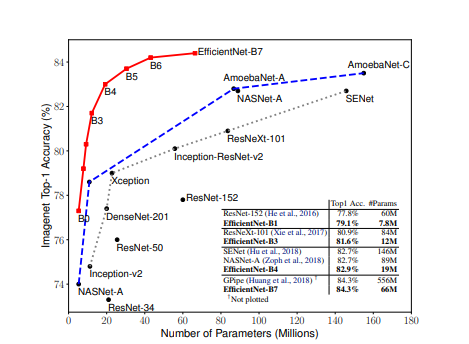

i am using collab, assume you have the zip file on collab


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change to the directory where your zip file is located (e.g., My Drive)
%cd /content/drive/My Drive/

/content/drive/My Drive


If you already have the unzipped data on your google drive, you can avoid running the next cell. Just make sure that the directory paths are correct in the config.

In [3]:
# Unzip the file
!unzip caption_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [5]:
import pickle
import re
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42) # this should be automatically called by torch.manual_seed(), but just to make sure
print(f"Using device: {device}")

Using device: cpu


In [6]:
# could be modified
class Config:
    # Paths
    IMAGE_DIR = "caption_data/Images"
    CAPTIONS_FILE = "caption_data/captions.txt"
    FEATURES_PATH = "caption_data/resnet_features.pt"
    VOCAB_PATH = "vocab.pkl"

    # Model
    EMBED_SIZE = 256
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    DROPOUT = 0.5

    NUM_WORKERS = 2 if torch.cuda.is_available() else 0

    # Training
    BATCH_SIZE = 64
    EPOCHS = 20
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-5
    GRAD_CLIP = 5.0

    # Data
    FREQ_THRESHOLD = 5  # could be modified
    MAX_SEQ_LEN = 50 # I don't think we need to use this

    # Splits
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1

cfg = Config()

In [7]:
train_transform = T.Compose([
    T.Resize((260, 260)),
    # T.RandomCrop((224, 224)), we can do that, but what if it crops the small neededed object
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), too brutal
    T.RandomGrayscale(p=0.02), # we can delete it because the color is important for us, we do not grey sky output
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # efficent Net is using Imagenet data for the training so using these values here wont be a data leakage because these are the values of the Imagenet, even though our data could be different this values work well
])

# no shenanigans for this one
val_transform = T.Compose([
    T.Resize((260, 260)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [8]:
class EfficientNetEncoder(nn.Module):
    """
    EfficientNet-B2 feature extractor - COMPLETELY FROZEN
    Only the projection layer is trainable
    """
    def __init__(self, embed_size):
        super().__init__()

        # Load pretrained EfficientNet-B2
        effnet = models.efficientnet_b2(
            weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1
        )

        # EfficientNet structure:
        # features -> avgpool -> classifier
        self.backbone = effnet.features
        self.avgpool = effnet.avgpool

        # Feature dimension for B2
        backbone_out = 1408

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Projection head (trainable)
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(backbone_out, embed_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, images):
        with torch.no_grad():
            x = self.backbone(images)
            x = self.avgpool(x)

        features = self.projection(x)
        return features


## Vocabulary, Dataset and DataLoader
The next step is to write the Vocabulary logic that assigns unique integers to words and a dataloader that loads an image and its captions, preprocesses them and hands them to the model.

In [9]:
class Vocabulary:
  def __init__(self, freq_threshold):
    self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"} # integers to tokens for specific token values
    # make sure that padding index is 0. it's important later on
    self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3} # token to integers
    self.freq_threshold = freq_threshold # only recognize words with abs frequency >= freq_threshold

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    """
    Simple tokenizer: lowercase, remove punctuation, split by space.
    """
    # This can be replaced with a library tokenizer
    # I am writing a simple custom one for now, as I think sub-word tokenization is not needed for our use-case
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text) # NOTE: we might need to write special logic for handling numeric tokens
    text = re.sub(r"\s+", " ", text).strip()
    return text.split(" ")

  def build_vocab(self, sentence_list):
    """
    Build a vocabulary of frequent words in sentence_list
    """
    frequencies = {}
    idx = 4 # we already have 4 words in our vocab (special tokens)

    # count the frequencies of all the words
    # NOTE: we might want to cap the vocabulary size. I am not doing it for now as I think it won't be needed for such a small dataset
    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence):
        if word not in frequencies: frequencies[word] = 1
        else: frequencies[word] += 1

    # assign an unique integer to words with abs frequency >= freq threshold
    # for determinism, sort by frequency (descending) and then alphabetically (ascending)
    sorted_words = sorted(frequencies.items(), key=lambda item: (-item[1], item[0]))
    for word, count in sorted_words:
      if count >= self.freq_threshold:
        self.stoi[word] = idx
        self.itos[idx] = word
        idx += 1

  def numericalize(self, text):
    """
    Convert a text string into a list of integers
    """
    # convert a text string into a list of integers
    tokenized_text = self.tokenizer_eng(text)
    return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"] for token in tokenized_text]

  def decode(self, ids, skip_special_tokens=True):
    """
    Reconstruct a sentence from integer vector
    """
    if skip_special_tokens:
        tokens = [self.itos.get(i, "<unk>") for i in ids if i not in [0, 1, 2]]  # skip <pad>, <start>, <end>
    else:
        tokens = [self.itos.get(i, "<unk>") for i in ids]
    return " ".join(tokens)

  def get_stats(self):
    return {
        "vocab_size": len(self),
        "num_special_tokens": 4,
        "num_words": len(self) - 4
    }

  def save_vocabulary(self, filename):
    """
    Saves vocabulary mappings to a file.
    """
    # use pickle instead of json so that integer keys are saved as integers
    with open(filename, "wb") as f:
      pickle.dump({
          "stoi": self.stoi,
          "itos": self.itos,
          "freq_threshold": self.freq_threshold
      }, f)
    print(f"Vocabulary saved to {filename}")

  @staticmethod
  def load_vocabulary(filename):
    """
    Loads a vocabulary from a file and returns a Vocabulary object
    """
    with open(filename, "rb") as f:
      data = pickle.load(f)

    vocab = Vocabulary(freq_threshold=data["freq_threshold"])
    vocab.stoi = data["stoi"]
    vocab.itos = data["itos"]

    print(f"Vocabulary loaded from {filename}")
    return vocab

In [10]:
class CaptionDataset(Dataset):
  def __init__(self, root_dir, images_list, captions_list, transform=None, freq_threshold=5, vocab=None):
    self.root_dir = root_dir
    self.transform = transform

    if not os.path.exists(root_dir):
      raise FileNotFoundError(f"Image directory not found: {root_dir}")

    self.imgs = images_list
    self.captions = captions_list

    # if a vocabulary is not passed in, build it
    if vocab is not None: self.vocab = vocab
    else:
      self.vocab = Vocabulary(freq_threshold)
      self.vocab.build_vocab(self.captions)

  def __len__(self):
    return len(self.captions)

  def __getitem__(self, index):
    # get image caption + id (which in this case is the file name)
    caption = self.captions[index]
    img_id = self.imgs[index]

    # load image
    img_path = os.path.join(self.root_dir, img_id)
    if not os.path.exists(img_path):
      raise FileNotFoundError(f"Image not found: {img_path}")

    img = Image.open(img_path).convert("RGB")


    # apply transformations
    if self.transform is not None: img = self.transform(img)

    # convert caption into a list of integers
    numericalized_caption = [self.vocab.stoi["<start>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<end>"]]

    return img, torch.tensor(numericalized_caption)

We cannot use the default pytorch data loader because the caption sentences are of different lengths and they cannot be stacked on top of each other. We need a custom function that will pad the batch to the length of the longest sentence in the batch.

In [11]:
class MyCollate:
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    # a batch is a list of tuples (image, caption)
    imgs = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    # stack images (they are all already resized to the same size through transform)
    imgs = torch.stack(imgs, dim=0)

    # pad captions. pad_sequence handles both padding and stacking
    targets = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)

    lengths = torch.tensor([len(c) for c in captions])

    return imgs, targets, lengths

In [14]:
# stratified train/val split to make sure that images are split between train/val to avoid data leakage
df = pd.read_csv(cfg.CAPTIONS_FILE)
unique_images = df["image"].unique()
np.random.shuffle(unique_images)
train_img_count = int(cfg.TRAIN_SPLIT * len(unique_images))
train_images = set(unique_images[:train_img_count])
val_images = set(unique_images[train_img_count:])

all_images = df["image"].tolist()
train_indices = [i for i, img in enumerate(all_images) if img in train_images]
val_indices = [i for i, img in enumerate(all_images) if img in val_images]

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}")
print(f"Train captions: {len(train_indices)}, Val captions: {len(val_indices)}")

import json
with open("/content/drive/MyDrive/val_images.json", "w") as f:
    json.dump(list(val_images), f)
print("Saved validation images list to val_images.json")

# build vocab only on training captions to avoid data leakage
all_captions = df["caption"].tolist()
train_captions = [all_captions[i] for i in train_indices]
vocab = Vocabulary(cfg.FREQ_THRESHOLD)
vocab.build_vocab(train_captions)
# vocab.save_vocabulary(cfg.VOCAB_PATH) # uncomment to save the vocabulary

print(f"Vocabulary size: {len(vocab)}")

train_dataset = CaptionDataset(
    root_dir=cfg.IMAGE_DIR,
    images_list=all_images,
    captions_list=all_captions,
    transform=train_transform,
    freq_threshold=cfg.FREQ_THRESHOLD,
    vocab=vocab
)

val_dataset = CaptionDataset(
    root_dir=cfg.IMAGE_DIR,
    images_list=all_images,
    captions_list=all_captions,
    transform=val_transform,
    freq_threshold=cfg.FREQ_THRESHOLD,
    vocab=vocab
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

pad_idx = vocab.stoi["<pad>"]

train_loader = DataLoader(
    train_subset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=MyCollate(pad_idx=pad_idx),
    pin_memory=True,
    persistent_workers=True if cfg.NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_subset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=MyCollate(pad_idx=pad_idx),
    pin_memory=True,
    persistent_workers=True if cfg.NUM_WORKERS > 0 else False
)

print(f"Train samples: {len(train_subset)}, Val samples: {len(val_subset)}")

Train images: 6472, Val images: 1619
Train captions: 32360, Val captions: 8095
Saved validation images list to val_images.json
Vocabulary size: 2668
Train samples: 32360, Val samples: 8095


## Decoder
Now, it's time to implement the decoder.

In [21]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
    super(DecoderRNN, self).__init__()

    # embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0) # num of embeddings = vocab_size, length of embed vector = embed_size

    # lstm layer
    self.lstm = nn.LSTM(
        input_size=embed_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout if num_layers > 1 else 0.0
    )

    # linear layer to convert lstm output to words score
    self.linear = nn.Linear(hidden_size, vocab_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, features, captions, lengths):
    """
    features: the image vectors (batch_size, embed_size)
    captions: word indices (batch_size, seq_length)
    lengths: the lengths of the sequences (batch_size)
    """
    # embed the captions, ignore the <end> token
    embeds = self.dropout(self.embedding(captions[:, :-1])) #dimensions: (batch_size, seq_length - 1, embed_size)

    # turn image features into (batch_size, 1, embed_size) size
    features = features.unsqueeze(1)

    #treat the features vector as the first word in sequence
    inputs = torch.cat((features, embeds), dim=1) #dimensions: (batch_size, seq_length, embed_size)

    packed = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)

    hiddens, _ = self.lstm(packed)
    hiddens, _ = pad_packed_sequence(hiddens, batch_first=True) # hiddens dimensions: (batch_size, sequence_length, hidden_size)
    outputs = self.linear(hiddens) #dimensions: (batch_size, sequence_length, vocab_size)
    return outputs


In [22]:
class CNNtoRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
    super(CNNtoRNN, self).__init__()
    self.encoder = EfficientNetEncoder(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

  def forward(self, images, captions, lengths):
    features = self.encoder(images)
    outputs = self.decoder(features, captions, lengths)
    return outputs

  def caption_image(self, image, vocabulary, max_length=50):
    """
    image: input image tensor (batch, channel, height, width)
    vocabulary: the Vocabulary object
    max_length: the maximum length of the caption output
    """
    self.eval()
    result_caption = []
    with torch.no_grad():
      # get image features
      x = self.encoder(image) # dim: (1, embed_size)
      x = x.unsqueeze(1) # dim: (1, 1, embed_size)

      # Initial LSTM states
      states = None

      # run the image through the LSTM
      hiddens, states = self.decoder.lstm(x, states) # hiddens dim: (1, 1, hidden_size)

      # start the loop with the <start> token
      start_token_idx = vocabulary.stoi["<start>"]

      next_word_input = torch.tensor([[start_token_idx]]).to(image.device)

      for _ in range(max_length):
        # embed the current word input
        embeds = self.decoder.embedding(next_word_input) # dim: (1, 1, embed_size)

        # run lstm, feed the states from the previous step back in
        hiddens, states = self.decoder.lstm(embeds, states) # dim: (1, 1, hidden_size)

        # calculate the output probabilities
        output = self.decoder.linear(hiddens[:, -1, :]) # dim: (1, vocab_size)

        # pick the word with the highest probability NOTE: this can be changed
        predicted = output.argmax(dim=1) # dim: (1)
        item = predicted.item()

        if item == vocabulary.stoi["<end>"]: break # if predicted <end> token, stop

        word = vocabulary.itos[item]
        if word not in ["<start>", "<pad>"]:
          result_caption.append(word)

        next_word_input = predicted.unsqueeze(1) # dim: (1, 1)

      return result_caption


## Model Initialization and Training

In [23]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

model = CNNtoRNN(
    embed_size=cfg.EMBED_SIZE,
    hidden_size=cfg.HIDDEN_SIZE,
    vocab_size=len(vocab),
    num_layers=cfg.NUM_LAYERS
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)

model.train()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 101MB/s] 


CNNtoRNN(
  (encoder): EfficientNetEncoder(
    (backbone): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sca

In [24]:
print("Starting Training...")

loss_history = []

for epoch in range(cfg.EPOCHS):
    if cfg.NUM_WORKERS > 0:
        loop = tqdm(train_loader, leave=True)
    else:
        loop = train_loader

    for idx, (imgs, captions, lengths) in enumerate(loop):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions, lengths)

        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.GRAD_CLIP)

        optimizer.step()

        if cfg.NUM_WORKERS > 0:
            loop.set_description(f"Epoch [{epoch+1}/{cfg.EPOCHS}]")
            loop.set_postfix(loss=loss.item())
        elif idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{cfg.EPOCHS}], Step [{idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    loss_history.append(loss.item())

    # Save checkpoint, training on T4 takes ~3 hours apparently
    if (epoch + 1) % 5 == 0:
         checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "config": cfg.__dict__,
            "vocab": vocab # Save vocab object just in case
        }
         save_checkpoint(checkpoint, filename=f"checkpoint_epoch_{epoch+1}.pth.tar")

# Save final model
final_checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "config": cfg.__dict__,
    "vocab": vocab
}
save_checkpoint(final_checkpoint, filename="final_model.pth.tar")
print("Training Complete and Model Saved!")

Starting Training...


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint
Training Complete and Model Saved!


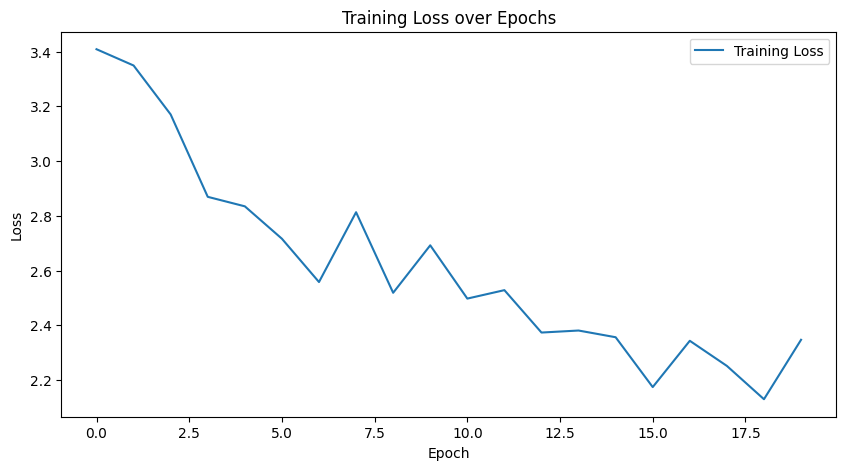

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()